# Portfoliobenadering betrouwbaarheidseisen
De betrouwbaarheidseisen in de NEN 8700 (bv. $\beta_T = 1.8$ voor afkeurniveau CC1b) hebben betrekking op individuele constructies. Asset owners met grote aantallen constructies in hun portfolio moeten zich afvragen of hanteren van het wettelijke (publiekrechtelijke) afkeurniveau wenselijk is in verband met potentieel onwenselijk hoge schadefrequenties frequenties in hun asset portfolio. Dit was ook de aanleiding voor RWS om het gebruiksniveau voor bruggen in te stellen.

In onderstaande analyse wordt nagegaan welke schadefrequenties te verwachten zijn bij hanteren van het afkeurniveau uit de NEN 8700, ervan uitgaande dat kademuren grotendeels in gevolgklasse CC1b vallen.

## Uitgangspunten en definities
Hieronder volgen de uitgangspunten en definities voor de analyse, te weten:
- parameters relevant voor het portfolio van kademuren in Amsterdam (en hun toetsing)
- grenstoestandsfunctie (voor de faalkansanalyse per constructie)
- unity check (UC) definitie
- onzekerheden (variatiecoefficienten)
- partiele factoren

### Portfolio kademuren
De volgende parameters zijn relevant voor de portfolio analyse:
- het aantal ("onafhankelijke kades"): $n_{kades}$
- de referentieperiode van de faalkans en UC (belastingstatistiek): $t_{ref}$
- de te toetsen restlevensduur: $t_{rest}$
- het aandeel constructies dat naar verwachting goedgekeurd wordt voor de restlevensduur: $goed$

In de analyse wordt vervolgens ervan uitgegaan dat afgekeurde constructies worden versterkt, en dat deze na versterking een verwaarloosbare faalkans hebben t.o.v. de bestaande portfolio. Voor de het schatten van de schadefrequentie wordt dat ook uitgegaan van het aantal goedgekeurde kades: $n_{con} = n_{kades} * goed$

Belangrijk voor de analyse (met name de correlatie tussen constructies) is het aandeel veranderlijke belasting ten opzichte van de permanente belasting, uitgedrukt in parameter $a_Q$ (zie definitie onder 'Grenstoestandsfunctie'). 

Verder kan ervan worden uitgegaan dat niet alle goedgekeurde kades (voor de kritieke grenstoestand) precies voldoen aan de afkeureis (cq. $UC = 1$), maar met enige marge. Dit wordt meegenomen door een range van UC waarden te beschouwen voor de goegekeurde constructies (hier met een uniforme verdeling tussen $UC_{range}$).

Daarnaast betekent het overschrijden van de grenstoestand niet automatisch schade of instorten. In deze analyse wordt hiermee rekening gehouden door een conditionele kans op schade (bij overschrijden grenstoestand) te hanteren: *p_cond_damage*.

#### Parameters:

In [14]:
import numpy as np

n_kades = 300
t_ref = 15
t_rest = 15
goed = 0.9
n_con = int(round(n_kades * goed))
aQ = 0.1
UC_range = np.array([0.7, 1.0])
p_cond_damage = 0.1

0.7


### Grenstoestandsfunctie
Voor de grenstoestandsfunctie wordt een generieke Z-functie gebruikt met genormaliseerde stochasten, vergelijkbaar met kalibratiestudies voor de Eurocodes. Hierbij wordt onderscheid gemaakt tussen sterkte en belasting (veranderling en permanent), en de gerelateerde modelonzekerheden. De design parameter $p$ zorgt dan voor de juiste verhouding van sterkte en belasting om aan de eisen te voldoen (bv. betrouwbaarheidsindex $\beta_T$ of unity check (UC). Bij de parameters wordt vermeld inhoeverrde deze gecorreleerd zijn tussen constructies (kades) en in de tijd. Deze correlatie is belangrijk voor het niet overschatten van faalkansen en schadefrequenties. 

$$ Z = p * m_R * R - a_Q * m_Q * Q - (1 - a_Q) * G $$

met 
- $p$ = design parameter (verhouding sterkte/belasting)
- $m_R$ = modelonzekerheid sterkte (tijdsonafhankelijk, volledig gecorreleerd in de tijd; volledige correlatie tussen constructies)
- $R$ = sterkte (tijdsonafhankelijk, volledig gecorreleerd in de tijd; geen correlatie tussen constructies)
- $a_Q$ = aandeel veranderlijke belasting van totale belasting (cq. veranderlijk plus permanent)
- $m_Q$ = modelonzekerheid veranderlijke belasting (tijdsonafhankelijk, volledig gecorreleerd in de tijd; volledige correlatie tussen constructies)
- $Q$ = veranderlijke belasting (tijdsafhankelijk, ongecorreleerd tussen jaren; geen correlatie tussen constructies)
- $G$ = permanente belasting (eigen gewicht; volledig gecorreleerd in de tijd; geen correlatie tussen constructies)

In [3]:
def LimitStateFunction(p, mR, R, aQ, mQ, Q, G):
    Z = p * mR * R - aQ *  mQ *Q - (1-aQ) * G
    return Z

### Variatiecoefficienten
Zoals hierboven beschreven gebruikt de grenstoestandsfunctie genormaliseerde stochasten, met verwachtingswaarden gelijk aan 1. De relatieve onzekerheid per variabele wordt uitgedrukt in de variatiecoefficienten zoals hieronder gedefinieerd. De getalswaarden betreffen schattingen die vergelijkbaar zijn met kalibratiestudies voor de Eurocodes.

In [4]:
V_mR = 0.12
V_R = 0.15
V_mQ = 0.1
V_Q = 0.15
V_G = 0.05

### Unity check (UC)
De unity check (UC) gebruikt dezelfde grootheden als de grenstoestandsfunctie hierboven, alleen worden er in plaats van stochasten karakteristieke waarden in combinatie met partiele factoren gebruikt volgende de Eurocode conventies, en de getalswaarden voor bestaande constructies uit de NEN 8700 serie. De karakteristieke waarden worden eveneens volgens Eurocode conventies bepaald bij een bepaald kwantiel.

$$ UC = \frac{a_Q * Q_{kar} * \gamma_Q - (1 - a_Q) * G_{kar} * \gamma_G}{p * R_{kar} / \gamma_R} $$

met 
- $p$ = design parameter (verhouding sterkte/belasting)
- $R_{kar}$ = karakteristieke waarde sterkte (5%-kwantiel $R$)
- $a_Q$ = aandeel veranderlijke belasting
- $Q_{kar}$ = karakteristieke waarde veranderlijke belasting (98%-kwantiel $Q$, cq. overschrijding gemiddeld eens per 50 jaar)
- $G_{kar}$ = karakteristieke waarde permanente belasting (50%-kwantiel $G$)

Voor het bepalen van de kwantielen wordt net als in de faalkansanalyse bij benadering uitgegaan van normale verdelingen.

In [5]:
from scipy.stats import norm

def UnityCheck(p, V_R, gamma_R, V_Q, gamma_Q, gamma_G):  # bepaal UC for gegeven p (design parameter)
    R_kar = 1 - 1.645 * V_R
    Q_kar = norm.ppf(0.98, loc = 1, scale = V_Q)
    G_kar = 1
    UC = (aQ * Q_kar * gamma_Q + (1-aQ) * G_kar * gamma_G) / (p * R_kar / gamma_R)
    return UC

def Get_P_for_UC(UC, V_R, gamma_R, V_Q, gamma_Q, gamma_G):  # bepaal p (design parameter) for gegeven UC
    R_kar = 1 - 1.645 * V_R
    Q_kar = norm.ppf(0.98, loc = 1, scale = V_Q)
    G_kar = 1
    p =  (aQ * Q_kar * gamma_Q + (1-aQ) * G_kar * gamma_G) / (UC * R_kar / gamma_R)
    return p

### Partiele factoren
De partiele factoren in NEN 8700 zijn gekoppeld aan de gevolgklasse en de belastingsituatie.

In [6]:
gamma_R = 1.1  # CC1b
gamma_Q = 1.05  # CC1b (6.10b)
gamma_G = 1.00  # CC1b (6.10b)

## Analyse

### Faalkansanalyse (MCS met numpy)
#### Realisaties stochasten en evaluatie grenstoestandsfunctie

In [20]:
from scipy.stats import truncnorm, expon

p_range = Get_P_for_UC(UC_range, V_R, gamma_R, V_Q, gamma_Q, gamma_G)
# p = 1.50  # design parameter ('verhouding sterkte versus belasting gemiddeld')

n_mcs = int(5e+4)  # aantal realisaties in Monte Carlo analyse

# UC = np.random.uniform(UC_range.min(), UC_range.max(), n_con)
# UC = truncnorm.rvs(UC_range.min(), UC_range.max(), loc=1.0, scale=((UC_range.max()-UC_range.min())/3), size=n_con)
UC = UC_range.max() - expon.rvs(loc=0.0, scale=((UC_range.max()-UC_range.min())/3), size=n_con)

p = Get_P_for_UC(UC, V_R, gamma_R, V_Q, gamma_Q, gamma_G)
mR = np.random.randn(n_mcs) * V_mR + 1.0
R = np.random.randn(n_mcs, n_con) * V_R + 1.0
mQ = np.random.randn(n_mcs) * V_mQ + 1.0
Q = np.random.randn(n_mcs, n_con) * V_mQ + 1.0
G = np.random.randn(n_mcs, n_con) * V_G + 1.0

for con in range(0, n_con):
    Zi = LimitStateFunction(p[con], mR, R[:,con], aQ, mQ, Q[:,con], G[:,con])
    if con == 0:
        Z = Zi
    else:
        # Z = np.append(Z, Zi).reshape((n_mcs, con+1)) # reshape werkt niet als bedoeld...
        Z = np.column_stack((Z, Zi))


#### Bepalen faalkansen en schadefrequenties

In [21]:
Fail = Z<0
Damage = p_cond_damage * Fail
Pf_con = Fail.sum(axis=0)/n_mcs
beta_con = norm.ppf(1-Pf_con)
Pf_con_gem = np.average(Pf_con)
beta_con_gem = norm.ppf(1-Pf_con_gem)

Pf_port_onafh = 1 - np.prod((1-Pf_con))

n_fail_port = Fail.sum(axis=1)
Pf_port = sum(n_fail_port>0) / n_mcs 
EF_port = n_fail_port.sum(axis=0)/n_mcs

PD_port = Pf_port * p_cond_damage
ED_port = EF_port * p_cond_damage

### Resultaten
In de resultaten hieronder wordt onderscheid gemaakt tussen falen en schade:
- Falen voor een constructie houdt in dat de grenstoestand overschreden wordt. Dat impliceert niet meteen schade of instorten.
- De faalkans voor het portfolio heeft betrekking op de kans op het falen van minimaal 1 constructie in het portfolio (in de restlevensduur).
- De verwachtingswaarde falen is de verwachtingswaarde voor het aantal gefaalde constructies in de restlevensduur. Let wel, er kunnen meerdere constructies tegelijk falen.
- Het verschil tussen schade en falen zit in de conditionele kans op schade gegeven falen, wat rekening houdt met het feit dat er in de formulering van de grenstoestand nog verborgen sterktes zitten, en dat constructies herverdelingscapaciteit hebben.

In [22]:

print('Aantal goedgekeurde constructies:', n_con )
print('Range UC-waarden (uniforme verdeling):', UC_range)
print('Faalkans per constructie (gemiddeld):', '{:.1e}'.format(Pf_con_gem))
print('Beta per constructie (gemiddeld):', round(beta_con_gem,2))
print('Faalkans portfolio (minimaal 1 kade, per 15 jaar) "onafhankelijk":', round(Pf_port_onafh,2))
print('Faalkans portfolio (minimaal 1 kade, per 15 jaar) met correlatie:', round(Pf_port,2))
print('Verwachtingswaarde falen (per 15 jaar):', round(EF_port,2))
print('Schadekans portfolio (per 15 jaar)', round(PD_port,2))
print('Verwachtingswaarde schades (per 15 jaar):', round(ED_port,2))
print('Verwachtingswaarde schades (per jaar):', round(ED_port/t_ref, 3), '(benadering)') # benadering: F/n jaar

Aantal goedgekeurde constructies: 270
Range UC-waarden (uniforme verdeling): [0.7 1. ]
Faalkans per constructie (gemiddeld): 1.7e-02
Beta per constructie (gemiddeld): 2.12
Faalkans portfolio (minimaal 1 kade, per 15 jaar) "onafhankelijk": 0.99
Faalkans portfolio (minimaal 1 kade, per 15 jaar) met correlatie: 0.72
Verwachtingswaarde falen (per 15 jaar): 4.59
Schadekans portfolio (per 15 jaar) 0.07
Verwachtingswaarde schades (per 15 jaar): 0.46
Verwachtingswaarde schades (per jaar): 0.031 (benadering)


### Figuren

Text(0, 0.5, 'relatieve frequentie')

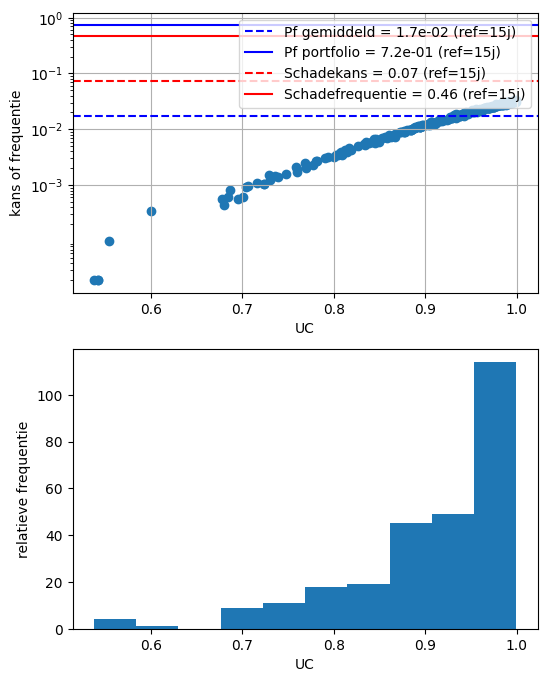

In [23]:
import matplotlib.pyplot as plt

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=[1])
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
# plot_loghist(Pf_con, 10)
# ax.set_xticks([1e-4, 1e-3, 1e-2, 0.1, 1])
ax[0].scatter(UC,Pf_con)
ax[0].set_yscale('log')
ax[0].axhline(y = Pf_con_gem, color = 'b', linestyle = '--', label = 'Pf gemiddeld = %1.1e (ref=15j)'%Pf_con_gem)
ax[0].axhline(y = Pf_port, color = 'b', linestyle = '-', label = 'Pf portfolio = %1.1e (ref=15j)'%Pf_port)
ax[0].axhline(y = PD_port, color = 'r', linestyle = '--', label = 'Schadekans = %.2f (ref=15j)'%PD_port)
ax[0].axhline(y = ED_port, color = 'r', linestyle = '-', label = 'Schadefrequentie = %.2f (ref=15j)'%ED_port)
ax[0].set_yticks([1e-3, 1e-2, 0.1, 1])
ax[0].set_xlabel('UC')
ax[0].set_ylabel('kans of frequentie')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].hist(UC)
ax[1].set_xlabel('UC')
ax[1].set_ylabel('relatieve frequentie')



## Next steps
- afstemmen uitgangspunten met PBK
- restlevensduur nu gelijk aan referentieperiode 15 jaar, uitbreiden naar 30 jaar?
- betere verdeling UC waarden bij oordeel voldoende? 
- ... (zie PvA offerte)

# Aantekeningen
- onafh aantal kades baseren op, of ARKbeoordelingen of onafhankelijke lengtes
- verwacht aantal goedgekeurd baseren op ARK
- DONE: UC formule corrigeren
- DONE: check gammas voor R, Q en G (gamma_R niet goed gedefinieerd)
- aanvaardbare schadefrequentie? (recente faalgevallen afgekeurd?)
- restlevensduur 30 jaar?
- ...